# Loan status prediction:

#### Competition link : <a href = https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/> Loan prediction practcise problem </a>

##### Steps:
<b>1) Data cleaning and preprocessing</b><br>
<b> 2) EDA</b><br>
 3) Creating and testing models<br>
 4) Model explanation

## Data cleaning and preprocessing:

In [1]:
# Impot necessary modules and dataset

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline


In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [4]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


<br>

#### There are 7 categorical features : 
Gender(Male, Female)<br>
Married(No, Yes)<br>
Dependents(0,1,2,3+)<br>
Education(Graduate, Non-graduate)<br>
Self_Employed(No, Yes)<br>
Property_Area(Urban, Semi-urban, Rural)<br>
Credit_History(1.0,0.0)<br>

Out of these credit history column is already encoded. The rest need to be encoded with either onehot or ordinal encoding.
We will onehot encode gender, marriage status, self emplyed status and property area. Education has only two distinct values, so ordinal encoding will be the same as on hot encoding. We will encode dependents feature ordinally.

Now, look at the missing values.

In [6]:
print("Train_missing values:\n", train.isna().sum().sort_values(ascending = False), "\nTest missing values:\n",
      test.isna().sum().sort_values(ascending = False), sep = "\n")

Train_missing values:

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Loan_ID               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
Loan_Status           0
dtype: int64

Test missing values:

Credit_History       29
Self_Employed        23
Gender               11
Dependents           10
Loan_Amount_Term      6
LoanAmount            5
Loan_ID               0
Married               0
Education             0
ApplicantIncome       0
CoapplicantIncome     0
Property_Area         0
dtype: int64


<br> Married column has 3 missing values in train data and none in test data. We can just drop these three rows completely, or impute the most frequent value. We will drop these rows.

In [8]:
train = train.dropna(subset=["Married"]).reset_index(drop=True)

Separate the features and target and encode target values.

In [10]:
le = LabelEncoder()
train_y = le.fit_transform(train["Loan_Status"])
train_x = train.drop(["Loan_Status"], axis = 1)

<br> Using column transformer and pipeline modules from scikit-learn package, all the preprocessing for both train and test data can be done quickly in one single step instead of cleaning and handling each column from both datasets seperately.

In [11]:
# Preprocessor function
ct = make_column_transformer(("passthrough", ["Loan_ID"]),
                            (make_pipeline(SimpleImputer(strategy="constant", fill_value="unknown"),
                                          OneHotEncoder()), ["Gender"]),
                            (OneHotEncoder(drop = "first"), ["Married"]),
                            (make_pipeline(SimpleImputer(strategy="most_frequent"),
                                          OrdinalEncoder(categories = [["0","1","2","3+"]])), ["Dependents"]),
                            (OneHotEncoder(drop = "first"), ["Education"]),
                            (make_pipeline(SimpleImputer(strategy="constant", fill_value="unknown"),
                                          OneHotEncoder()), ["Self_Employed"]),
                            ("passthrough", ["ApplicantIncome", "CoapplicantIncome"]),
                            (IterativeImputer(estimator=RandomForestRegressor()), ["LoanAmount"]),
                            (SimpleImputer(strategy="most_frequent"), ["Loan_Amount_Term"]),
                            (IterativeImputer(estimator=LogisticRegression(max_iter=1000)), ["Credit_History"]),
                            (OneHotEncoder(), ["Property_Area"]))

In [12]:
train_transformed = ct.fit_transform(train_x)

In [13]:
columns = ['Loan_ID', 'Gender_Female', 'Gender_Male','Gender_nan', 'Married_Yes',
           'Dependents','Education_Not Graduate', 'Self_Employed_No', 'Self_Employed_Yes','Self_Employed_nan',
           'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 
        'Property_Area_Rural', 'Property_Area_Semiurban', 'Property_Area_Urban']

In [14]:
train_preprocessed = pd.DataFrame(train_transformed, columns = columns)

In [15]:
test_transformed = ct.transform(test)
test_preprocessed = pd.DataFrame(test_transformed, columns = columns)

<br> Add the target column back to train data to make completely cleaned train data.

In [16]:
train_preprocessed["Loan_Status"] = train_y

In [17]:
print(train_preprocessed.shape, test_preprocessed.shape)

(611, 19) (367, 18)


In [18]:
# Save the preprocessed datasets
train_preprocessed.to_csv("train_preprocessed.csv", index = False)
test_preprocessed.to_csv("test_preprocessed.csv", index = False)

## 2) EDA

In [18]:
train_df = train_preprocessed.drop(["Loan_ID"], axis = 1).astype("float")

<br> Lets look at the distribution of target variable.

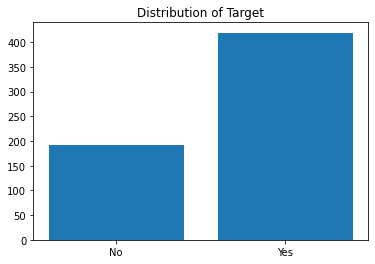

In [20]:
plt.bar(train_df["Loan_Status"].value_counts().index, train_df["Loan_Status"].value_counts().values)
plt.xticks([0,1], ["No", "Yes"])
plt.title("Distribution of Target")
plt.show()

<br> There are more than twice as much approved loans than denied. This may cause the model to be biased and falsely predict class 1 (approved). This can be resolved by either undersampling the majority class or oversampling the minority class. 
<br>
As the dataset itself is small, we will use oversampling.

Let's look at the correlation between features and target and between each of the features.

<AxesSubplot:>

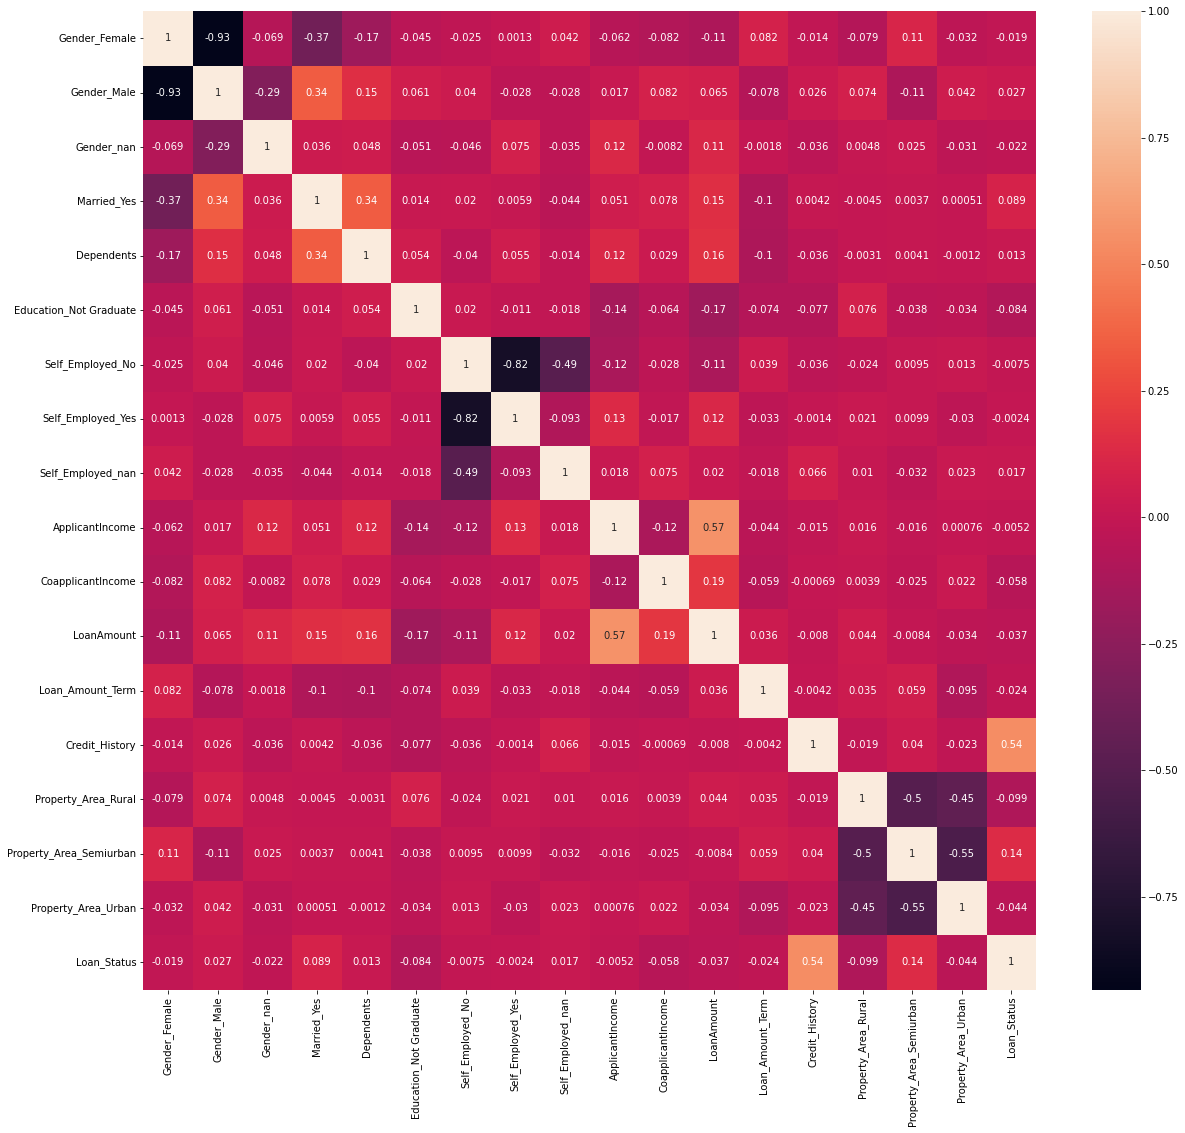

In [22]:
plt.figure(figsize = (20,18))
sns.heatmap(train_df.corr(), annot = True)

<br> The feature Credit_History has the highest positive correlation coefficient with the target.

As we can see, some of the features are also highly correlated with each other. We may need to remove those before fitting linear models like logistic regression.